In [1]:
using Base.Threads
using ProgressMeter
using Plots
nthreads()
xoxp1(x) = x/(x+1) # {x > 0} -> {0 < y < 1}

xoxp1 (generic function with 1 method)

In [2]:
using DynamicalSystems
using StaticArrays

In [3]:
function f(x, p)
   r, k = p
   a, mu, d = 5.0, 0.5, 0.2
   x1new = x[1]*exp(r*(1-x[1]/k)-x[2]/(a+x[1]^2))
   x2new = x[2]*exp(mu*x[1]/(a+x[1]^2)-d)
   x1new, x2new
end

f(x, p, t) = SVector(f(x, p))

f (generic function with 2 methods)

In [4]:
function traj2d!(tr1, tr2, f, p, x0, niters, nwarmup)
    x = x0
    for _ in 1:nwarmup
        x = f(x, p)
    end
    @inbounds tr1[1], tr2[1] = x
    for i in 2:niters+1
        x = f(x, p)
        @inbounds tr1[i], tr2[i] = x
    end
end

traj2d! (generic function with 1 method)

In [5]:
function traj2d_ds!(tr1, tr2, dds, niters, nwarmup)
    integ = integrator(dds, dds.u0)
    nwarmup != 0 && step!(integ, nwarmup)
    @inbounds tr1[1], tr2[1] = DynamicalSystems.DynamicalSystemsBase.obtain_access(integ.u, nothing)
    for i in 2:niters+1
        step!(integ)
        @inbounds tr1[i], tr2[i] = DynamicalSystems.DynamicalSystemsBase.obtain_access(integ.u, nothing)
    end
end

traj2d_ds! (generic function with 1 method)

In [6]:
niters = 10
nwarmup = 10
tr1 = zeros(Int, niters+1)
tr2 = similar(tr1)
traj2d!(tr1, tr2, ((a, b), p) -> (b, a+b), nothing, (0, 1), niters, nwarmup)
@show tr1 tr2;

tr1 = [55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765]
tr2 = [89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946]


In [7]:
function findperiod(x; tol=1e-3)
    n = length(x)
    @inbounds for k in 2:(n ÷ 2 + 1)
        if abs(x[k] - x[1]) ≤ tol
            all(j -> abs(x[j] - x[j-k+1]) ≤ tol, k:n) && return k - 1
        end
    end 
    return n
end

findperiod (generic function with 1 method)

In [8]:
x = [1, 2, 3, 4, 1, 2, 3]
findperiod(x)

7

In [9]:
x = [1, 2, 3, 4, 1, 2, 3, 4]
findperiod(x)

4

In [10]:
x = [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3]
findperiod(x)

4

In [11]:
x = @. sinpi(0:0.1:10) + 1e-4randn()
findperiod(x)

20

In [12]:
niters = 2000
nwarmup = 50000
tr1_ds = zeros(niters+1)
tr2_ds = similar(tr1)
x0 = (0.4, 0.5)
p = (2.5, 4.0)
dds = DiscreteDynamicalSystem(f, SVector(x0), collect(p))
traj2d_ds!(tr1_ds, tr2_ds, dds, niters, nwarmup)
@show tr1_ds[1:10];

LoadError: InexactError: Int64(1.5e-323)

In [13]:
niters = 2000
nwarmup = 50000
tr1 = zeros(niters+1)
tr2 = similar(tr1)
x0 = (0.4, 0.5)
p = (2.5, 4.0)
traj2d!(tr1, tr2, f, p, x0, niters, nwarmup)
@show tr1[1:10];

tr1[1:10] = [6.841647133951477, 1.1583528660485214, 6.841647133951486, 1.1583528660485158, 6.8416471339514775, 1.1583528660485207, 6.8416471339514855, 1.1583528660485163, 6.841647133951477, 1.1583528660485214]


In [14]:
tr1_ds == tr1

false

In [15]:
@btime traj2d!($tr1, $tr2, f, p, x0, niters, nwarmup)
@btime traj2d_ds!($tr1_ds, $tr2_ds, dds, niters, nwarmup);

LoadError: LoadError: UndefVarError: @btime not defined
in expression starting at In[15]:1

In [16]:
function calcperiod2d!(tr1, tr2, f, p, x0, niters, nwarmup; tol=1e-3)
    traj2d!(tr1, tr2, f, p, x0, niters, nwarmup)
    findperiod(tr1; tol)
end

calcperiod2d! (generic function with 1 method)

In [17]:
using BenchmarkTools
@btime calcperiod2d!($(zeros(2001)), $(zeros(2001)), f, (2.6, 4.0), (0.4, 0.5), 2000, 50000; tol=1e-3)

  4.183 ms (0 allocations: 0 bytes)


4

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23mm9mm


 23.874924 seconds (1.61 M allocations: 92.468 MiB, 0.15% gc time, 3.29% compilation time)


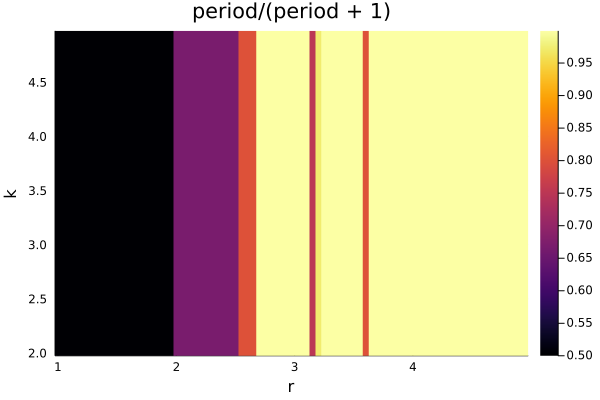

In [18]:
function calcperiod2d(f = f, niters = 2000, nwarmup = 50000, x0 = (0.4, 0.5),
        r = (1:0.05:5)[1:end-1], k = (2:0.05:5)[1:end-1], tol=1e-3
    )
    tr1 = Vector{Float64}(undef, niters+1)
    tr2 = similar(tr1)
    period = Matrix{Int}(undef, length(r), length(k))
    prog = Progress(length(r)*length(k))
    for j in eachindex(k)
        for i in eachindex(r)
            @inbounds period[i, j] = calcperiod2d!(tr1, tr2, f, (r[i], k[j]), x0, niters, nwarmup; tol)
            next!(prog)
        end
    end
    period, r, k
end

period, r, k = @time calcperiod2d()
heatmap(r, k, xoxp1.(period'); xlabel="r", ylabel="k", title="period/(period + 1)")

In [19]:
function calcperiod2d_threads(f = f, niters = 2000, nwarmup = 50000, x0 = (0.4, 0.5),
        r = (1:0.05:5)[1:end-1], k = (2:0.05:5)[1:end-1], tol=1e-3
    )
    tr1 = [Vector{Float64}(undef, niters+1) for _ in 1:nthreads()]
    tr2 = [Vector{Float64}(undef, niters+1) for _ in 1:nthreads()]
    period = Matrix{Int}(undef, length(r), length(k))
    #prog = Progress(length(r)*length(k))
    @threads for j in eachindex(k)
        tid = threadid()
        for i in eachindex(r)
            @inbounds period[i, j] = calcperiod2d!(tr1[tid], tr2[tid], f, (r[i], k[j]), x0, niters, nwarmup; tol)
            #next!(prog)
        end
    end
    period, r, k
end

calcperiod2d_threads (generic function with 8 methods)

In [20]:
period, r, k_th, r, k = @time calcperiod2d_threads(); flush(stdout)
period, r, k_th, r, k = @time calcperiod2d_threads(); flush(stdout)
period, r, k_th, r, k = @time calcperiod2d_threads(); flush(stdout)
heatmap(r, k, xoxp1.(period_th'); xlabel="r", ylabel="k", title="period/(period + 1)")

  3.071326 seconds (407.54 k allocations: 26.321 MiB, 2.87% compilation time)


LoadError: BoundsError: attempt to access Tuple{Matrix{Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}} at index [4]

In [21]:
period, r, k_th = @time calcperiod2d_threads(); flush(stdout)
period, r, k_th = @time calcperiod2d_threads(); flush(stdout)
period, r, k_th = @time calcperiod2d_threads(); flush(stdout)
heatmap(r, k, xoxp1.(period_th'); xlabel="r", ylabel="k", title="period/(period + 1)")

  3.019271 seconds (113 allocations: 424.531 KiB)
  2.945049 seconds (112 allocations: 424.203 KiB)
  2.978982 seconds (112 allocations: 424.203 KiB)


LoadError: UndefVarError: period_th not defined

In [22]:
period == period_th

LoadError: UndefVarError: period_th not defined

In [23]:
period'

60×80 adjoint(::Matrix{Int64}) with eltype Int64:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  2001  2001  2001  2001  2001  2001
 1  1  1  1  1  1  1  1  1  1  1  1  1     2001  2001  2001  2001  2001  2001
 1  1  1  1  1  1  1  1  1  1  1  1  1     2001  2001  2001  2001  2001  2001
 1  1  1  1  1  1  1  1  1  1  1  1  1     2001  2001  2001  2001  2001  2001
 1  1  1  1  1  1  1  1  1  1  1  1  1     2001  2001  2001  2001  2001  2001
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  2001  2001  2001  2001  2001  2001
 1  1  1  1  1  1  1  1  1  1  1  1  1     2001  2001  2001  2001  2001  2001
 1  1  1  1  1  1  1  1  1  1  1  1  1     2001  2001  2001  2001  2001  2001
 1  1  1  1  1  1  1  1  1  1  1  1  1     2001  2001  2001  2001  2001  2001
 1  1  1  1  1  1  1  1  1  1  1  1  1     2001  2001  2001  2001  2001  2001
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  2001  2001  2001  2001  2001  2001
 1  1  1  1  1  1  1  1  1  1  1  1  1     2001  2001  2001  2001  2001  2001
 1  1  1  1  1

In [24]:
@btime calcperiod2d_threads(f; niters = 2000, nwarmup = 50000, x0 = (0.4, 0.5),
    r = (1:0.05:5)[1:end-1], k = (2:0.05:5)[1:end-1], tol=1e-3)

LoadError: MethodError: no method matching calcperiod2d_threads(::typeof(f); niters=2000, nwarmup=50000, x0=(0.4, 0.5), r=1.0:0.05:4.95, k=2.0:0.05:4.95, tol=0.001)
[0mClosest candidates are:
[0m  calcperiod2d_threads(::Any) at In[19]:1[91m got unsupported keyword arguments "niters", "nwarmup", "x0", "r", "k", "tol"[39m
[0m  calcperiod2d_threads(::Any, [91m::Any[39m) at In[19]:1[91m got unsupported keyword arguments "niters", "nwarmup", "x0", "r", "k", "tol"[39m
[0m  calcperiod2d_threads(::Any, [91m::Any[39m, [91m::Any[39m) at In[19]:1[91m got unsupported keyword arguments "niters", "nwarmup", "x0", "r", "k", "tol"[39m
[0m  ...

In [25]:
@code_warntype calcperiod2d_threads(f; niters = 2000, nwarmup = 50000, x0 = (0.4, 0.5),
    r = (1:0.05:5)[1:end-1], k = (2:0.05:5)[1:end-1], tol=1e-3)